# Определение возраста покупателей

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, Flatten, AvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## Исследовательский анализ данных

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
features, target = next(train_gen_flow)

Text(0.5, 1.0, 'Распределение возрастов')

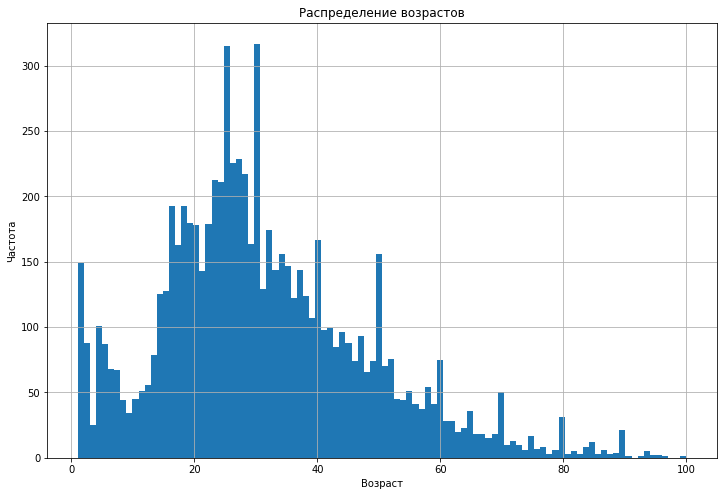

In [4]:
plt.figure(figsize=(12,8))
labels['real_age'].hist(bins=100,range=(1,100))
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.title('Распределение возрастов')

In [5]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

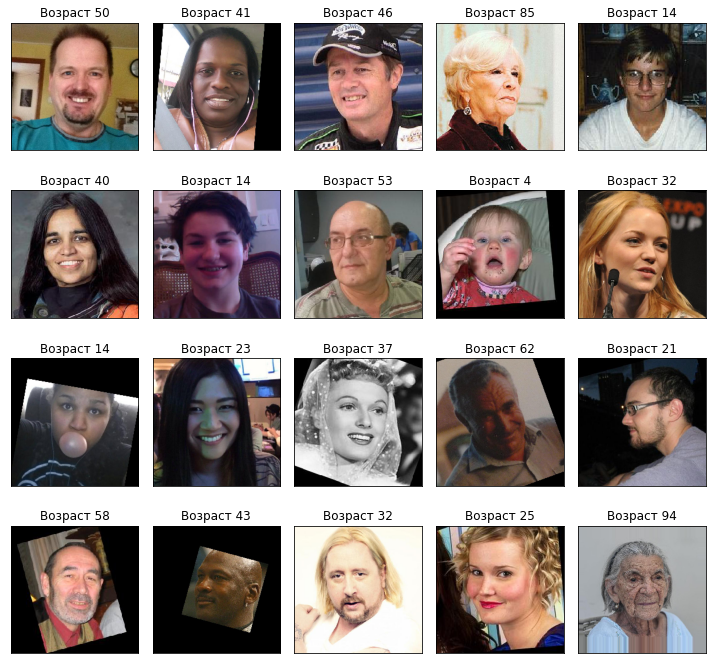

In [13]:
fig = plt.figure(figsize=(10,10))
for i in range(20):
    ax = fig.add_subplot(4, 5, i+1)
    ax.imshow(features[i]) 
    ax.set_xticks([])  
    ax.set_yticks([])  
    ax.set_title(f"Возраст {target[i]}")  
    plt.tight_layout()

Датасет представлен 7591 изображением с фотографиями людей. Наиболее часто встречаются люди возрастом от 20 до 40 лет. Также наблюдается небольшой пик с возрастом до 8 лет. На этих возрастах модель обучится лучше всего. Среднее значение возраста составляет 31 год, в то время как медиана - 29 лет, что свидетельствует о выбросах в сторону больших значений. <br>
Касаемо представленных фотографий, то стоит отметить, что ориентация фотографий в основном ровная вертикальная, но иногда наблюдаются фото с небольшим поворотом порядка 5-10 градусов, для улучшения качества можно применить аугментацию. Фото цветные. Большая часть изображений одинакового размера, редко встречаются фото меньшего размера, чем 224х224.

## Обучение модели

```python
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(validation_split=0.25, 
          rescale=1./255)
 
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow




def load_test(path):
    labels=pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.25, 
          rescale=1./255)
 
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow
 


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    opt_adam = Adam(lr=0.0001)
    model.compile(loss='mae',
                  optimizer=opt_adam ,
                  metrics=['mae'])
 
    return model
 
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=15,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model 

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/15
356/356 - 53s - loss: 10.2983 - mae: 10.2988 - val_loss: 13.3357 - val_mae: 13.3251
Epoch 2/15
356/356 - 43s - loss: 7.1181 - mae: 7.1182 - val_loss: 12.4531 - val_mae: 12.4511
Epoch 3/15
356/356 - 43s - loss: 6.0317 - mae: 6.0322 - val_loss: 7.1960 - val_mae: 7.1925
Epoch 4/15
356/356 - 43s - loss: 5.1878 - mae: 5.1879 - val_loss: 6.8937 - val_mae: 6.8967
Epoch 5/15
356/356 - 43s - loss: 4.6735 - mae: 4.6735 - val_loss: 6.5770 - val_mae: 6.5863
Epoch 6/15
356/356 - 43s - loss: 4.1723 - mae: 4.1720 - val_loss: 6.7163 - val_mae: 6.7209
Epoch 7/15
356/356 - 41s - loss: 3.6907 - mae: 3.6909 - val_loss: 7.1129 - val_mae: 7.1122
Epoch 8/15
356/356 - 41s - loss: 3.4448 - mae: 3.4449 - val_loss: 6.4527 - val_mae: 6.4584
Epoch 9/15
356/356 - 39s - loss: 3.1632 - mae: 3.1633 - val_loss: 6.1636 - val_mae: 6.1678
Epoch 10/15
356/356 - 38s - loss: 3.0216 - mae: 3.0214 - val_loss: 6.4829 - val_mae: 6.4907
Epoch 11/15
356/356 - 38s - loss: 2.7967 - mae: 2.7969 - val_loss: 6.9171 - val_mae: 6.9182
Epoch 12/15
356/356 - 38s - loss: 2.7201 - mae: 2.7202 - val_loss: 6.3018 - val_mae: 6.3174
Epoch 13/15
356/356 - 38s - loss: 2.5655 - mae: 2.5652 - val_loss: 6.4574 - val_mae: 6.4614
Epoch 14/15
356/356 - 39s - loss: 2.4692 - mae: 2.4690 - val_loss: 5.9928 - val_mae: 5.9999
Epoch 15/15
356/356 - 39s - loss: 2.4252 - mae: 2.4252 - val_loss: 6.6595 - val_mae: 6.6597
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 6.6595 - mae: 6.6597
Test MAE: 6.6597



## Анализ обученной модели

В рамках данного проекта разработана модель, способная определять приблизительный возраст человека по фотографии. Процесс включал в себя следующие этапы:

- Исследовательский анализ данных (EDA): Был проведен анализ набора данных для определения его основных характеристик, таких как размеры изображений, распределение возрастов, а также выявления возможных выбросов и несбалансированности классов возрастов.

- Подготовка данных к обучению: Изображения были предварительно обработаны, включая изменение размеров и нормализацию. Данные разделены на обучающую, валидационную выборки.

- Обучение нейронной сети: Была выбрана архитектура нейронной сети ResNet50 и определены гиперпараметры модели (20 эпох и алгоритм оптимизации Adam с lr=0.0001). Модель была обучена на обучающем наборе данных и показала низкое значение абсолютной ошибки MAE=2.4 года.

- Оценка качества модели: Модель оценена на тестовом наборе данных с помощью метрики mean absolute error, которая составила 6.7 лет. Видно небольшое переобучение, тем не менее MAE < 7 является хорошим результатом.